### **Drive Mount**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Imports**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, Sequential
from tensorflow.keras.layers import Conv2D,Dense,Dropout,Flatten,MaxPooling2D,Input,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

In [ ]:
x_train = np.load('/content/drive/MyDrive/Research Programs and Folders/NeuralIPS Code/Data/Processed Data/42850/x_train.npy')
x_val = np.load('/content/drive/MyDrive/Research Programs and Folders/NeuralIPS Code/Data/Processed Data/42850/x_val.npy')
x_test = np.load('/content/drive/MyDrive/Research Programs and Folders/NeuralIPS Code/Data/Processed Data/42850/x_test.npy')

y_train = np.load('/content/drive/MyDrive/Research Programs and Folders/NeuralIPS Code/Data/Processed Data/42850/y_train.npy')
y_val = np.load('/content/drive/MyDrive/Research Programs and Folders/NeuralIPS Code/Data/Processed Data/42850/y_val.npy')
y_test = np.load('/content/drive/MyDrive/Research Programs and Folders/NeuralIPS Code/Data/Processed Data/42850/y_test.npy')

In [ ]:
Test, Precision, Recall, F1, ROC_AUC = [], [], [], [], []

In [ ]:
y_test = np.array([np.argmax(i) for i in y_test])

### **MoE**

In [ ]:
def expert_cnn(input_dim, output_dim):
    model=Sequential()
    model.add(Conv2D(32,(3,3), padding='same',input_shape=input_dim, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(190, activation="relu"))
    model.add(Dense(190, activation="relu"))
    model.add(Dense(190, activation="relu"))
    model.add(Dense(190, activation="relu"))
    model.add(Dense(190, activation="relu"))
    model.add(Dense(190, activation="relu"))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [ ]:
def expert_alex(input_dim, output_dim):
    model=Sequential()
    model.add(Conv2D(96,(11,11), strides = 4, padding='same', input_shape=input_dim, activation='relu', kernel_initializer= 'he_normal'))
    model.add(MaxPooling2D(pool_size=(3,3), strides = 2, padding='same'))
    model.add(Conv2D(256,(5,5), strides = 1, padding='same', activation='relu', kernel_initializer= 'he_normal'))
    model.add(MaxPooling2D(pool_size=(3,3), strides = 2, padding='same'))
    model.add(Conv2D(384,(3,3), strides = 1, padding='same', activation='relu', kernel_initializer= 'he_normal'))
    model.add(Conv2D(384,(3,3), strides = 1, padding='same', activation='relu', kernel_initializer= 'he_normal'))
    model.add(Conv2D(256,(3,3), strides = 1, padding='same', activation='relu', kernel_initializer= 'he_normal'))
    model.add(MaxPooling2D(pool_size=(3,3), strides = 2, padding='same'))
    model.add(Flatten())#makes input/outputs match
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation="relu"))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

In [ ]:
def expert_vgg(input_dim, output_dim):
    model=Sequential()
    model.add(Conv2D(64,(3,3), strides = 1, padding='same', input_shape=input_dim, activation='relu', kernel_initializer= 'he_normal'))
    model.add(Conv2D(64,(3,3), strides = 1, padding='same', activation='relu', kernel_initializer= 'he_normal'))
    model.add(MaxPooling2D(pool_size=(3,3), strides = 2, padding='same'))
    model.add(Conv2D(128,(3,3), strides = 1, padding='same', activation='relu', kernel_initializer= 'he_normal'))
    model.add(Conv2D(128,(3,3), strides = 1, padding='same', activation='relu', kernel_initializer= 'he_normal'))
    model.add(MaxPooling2D(pool_size=(3,3), strides = 2, padding='same'))
    model.add(Conv2D(256,(3,3), strides = 1, padding='same', activation='relu', kernel_initializer= 'he_normal'))
    model.add(Conv2D(256,(3,3), strides = 1, padding='same', activation='relu', kernel_initializer= 'he_normal'))
    model.add(MaxPooling2D(pool_size=(3,3), strides = 2, padding='same'))
    model.add(Conv2D(512,(3,3), strides = 1, padding='same', activation='relu', kernel_initializer= 'he_normal'))
    model.add(Conv2D(512,(3,3), strides = 1, padding='same', activation='relu', kernel_initializer= 'he_normal'))
    model.add(Conv2D(512,(3,3), strides = 1, padding='same', activation='relu', kernel_initializer= 'he_normal'))
    model.add(MaxPooling2D(pool_size=(3,3), strides = 2, padding='same'))
    model.add(Conv2D(512,(3,3), strides = 1, padding='same', activation='relu', kernel_initializer= 'he_normal'))
    model.add(Conv2D(512,(3,3), strides = 1, padding='same', activation='relu', kernel_initializer= 'he_normal'))
    model.add(Conv2D(512,(3,3), strides = 1, padding='same', activation='relu', kernel_initializer= 'he_normal'))
    model.add(MaxPooling2D(pool_size=(3,3), strides = 2, padding='same'))
    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dense(4096, activation="relu"))
    model.add(Dense(4096, activation="relu"))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

In [ ]:
def gate_model(input_dim, num_experts):
    model=Sequential()
    model.add(Conv2D(32,(3,3), padding='same',input_shape=input_dim, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Flatten())
    model.add(Dense(num_experts, activation='softmax'))
    return model

In [ ]:
class MixtureOfExperts(tf.keras.Model):
    def __init__(self, input_dim, output_dim, num_experts):
        super(MixtureOfExperts, self).__init__()
        self.experts = [expert_cnn(input_dim, output_dim), expert_alex(input_dim, output_dim), expert_vgg(input_dim, output_dim)]
        self.gate = gate_model(input_dim, num_experts)
        self.output_layer = Dense(output_dim, activation='softmax')

    def call(self, inputs):
        expert_outputs = [expert(inputs) for expert in self.experts]
        gate_output = self.gate(inputs)
        weighted_expert_outputs = [tf.multiply(expert_output, tf.expand_dims(gate_output[:, i], axis=1))
                                   for i, expert_output in enumerate(expert_outputs)]
        aggregated_output = tf.reduce_sum(weighted_expert_outputs, axis=0)
        final_output = self.output_layer(aggregated_output)
        return final_output

In [ ]:
input_dim = (32,32,3)
output_dim = 2
num_experts = 3

In [ ]:
MoE = MixtureOfExperts(input_dim, output_dim, num_experts)
MoE.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='accuracy', patience=20,  min_delta=0.1)
MoE.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=64, verbose=2, callbacks = [early_stopping])

Epoch 1/100
469/469 - 26s - loss: 0.3843 - accuracy: 0.8974 - val_loss: 0.3032 - val_accuracy: 0.9197 - 26s/epoch - 56ms/step
Epoch 2/100
469/469 - 7s - loss: 0.2602 - accuracy: 0.9304 - val_loss: 0.2360 - val_accuracy: 0.9291 - 7s/epoch - 15ms/step
Epoch 3/100
469/469 - 7s - loss: 0.2061 - accuracy: 0.9411 - val_loss: 0.2047 - val_accuracy: 0.9368 - 7s/epoch - 15ms/step
Epoch 4/100
469/469 - 7s - loss: 0.1735 - accuracy: 0.9491 - val_loss: 0.1845 - val_accuracy: 0.9414 - 7s/epoch - 15ms/step
Epoch 5/100
469/469 - 7s - loss: 0.1503 - accuracy: 0.9553 - val_loss: 0.1974 - val_accuracy: 0.9333 - 7s/epoch - 15ms/step
Epoch 6/100
469/469 - 7s - loss: 0.1261 - accuracy: 0.9624 - val_loss: 0.1932 - val_accuracy: 0.9365 - 7s/epoch - 15ms/step
Epoch 7/100
469/469 - 8s - loss: 0.1074 - accuracy: 0.9688 - val_loss: 0.1852 - val_accuracy: 0.9351 - 8s/epoch - 16ms/step
Epoch 8/100
469/469 - 7s - loss: 0.0930 - accuracy: 0.9743 - val_loss: 0.2119 - val_accuracy: 0.9319 - 7s/epoch - 15ms/step
Epoch 

In [ ]:
history = pd.DataFrame(MoE.history.history)
history.to_csv('/content/drive/MyDrive/Research Programs and Folders/NeuralIPS Code/Models/Quebec Models/Training Results/Train_MoE.csv', index = False)

Maximum validation accuracy: 0.9414235949516296


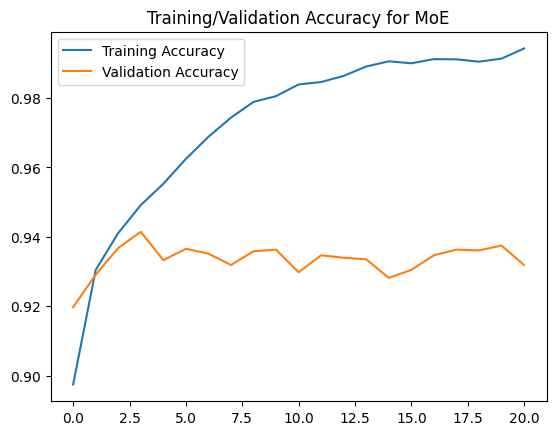

In [ ]:
history = pd.DataFrame(MoE.history.history)
print("Maximum validation accuracy: {}".format(history['val_accuracy'].max()))
plt.title('Training/Validation Accuracy for MoE')
plt.plot(history['accuracy'], label = 'Training Accuracy')
plt.plot(history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
y_hat_MoE = np.array([np.argmax(i) for i in MoE.predict(x_test)])

268/268 [==============================] - 2s 6ms/step


Testing Accuracy
Accuracy: 0.9323220536756126
Precision: 0.9133973288814691
Recall: 0.9636723910171731
F1 Score: 0.9378615813156203
ROC-AUC Score: 0.9303217963030255


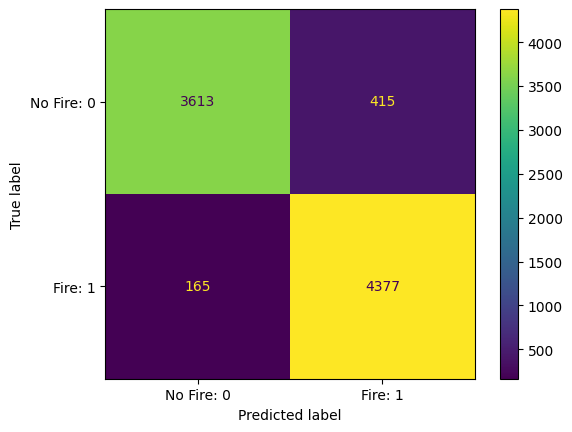

In [ ]:
print("Testing Accuracy")
print("Accuracy: {}".format(accuracy_score(y_true = y_test, y_pred = y_hat_MoE)))
print("Precision: {}".format(precision_score(y_true = y_test, y_pred = y_hat_MoE))) #True positive predictions/Total positive predictions
print("Recall: {}".format(recall_score(y_true = y_test, y_pred = y_hat_MoE)))#True positive predictions/Total number of positive instances
print("F1 Score: {}".format(f1_score(y_true = y_test, y_pred = y_hat_MoE)) )#Harmonic mean of precision and recall
print("ROC-AUC Score: {}".format(roc_auc_score(y_true = y_test, y_score = y_hat_MoE)))


confusion_matrix = metrics.confusion_matrix(y_true = y_test, y_pred = y_hat_MoE)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels= ["No Fire: 0", "Fire: 1"] )
cm_display.plot()
plt.show()

In [ ]:
Test.append(accuracy_score(y_true = y_test, y_pred = y_hat_MoE))
Precision.append(precision_score(y_true = y_test, y_pred = y_hat_MoE))
Recall.append(recall_score(y_true = y_test, y_pred = y_hat_MoE))
F1.append(f1_score(y_true = y_test, y_pred = y_hat_MoE))
ROC_AUC.append(roc_auc_score(y_true = y_test, y_score = y_hat_MoE))

### **Results**

In [ ]:
data_table = pd.DataFrame({'Models': ['MoE'], 'Accuracy':Test, 'Precision': Precision, 'Recall': Recall, 'F1_Score': F1, 'ROC-AUC':ROC_AUC})
data_table.sort_values('Accuracy', inplace=True, ascending = False)
data_table.reset_index(drop = True)

,Models,Accuracy,Precision,Recall,F1_Score,ROC-AUC
0,MoE,0.932322,0.913397,0.963672,0.937862,0.930322


In [ ]:
data_table.to_csv('/content/drive/MyDrive/Research Programs and Folders/NeuralIPS Code/Models/Quebec Models/Separated Results/Results_MoE.csv', index = False)